## Load-in dependencies:

In [78]:
using Pkg
# Pkg.add("Profile")
# Pkg.instantiate()

In [79]:
#= dependencies = ["DelimitedFiles", "LinearAlgebra", "Optim", "Distributions", "Test",
                "BenchmarkTools", "Random", "CSV", "DataFrames", "Distributed", "Plots"];
Pkg.add(dependencies) =#

In [1]:
using DelimitedFiles
using LinearAlgebra
using Optim
using Distributions
using Test
using BenchmarkTools
using Random
using CSV
using DataFrames
using Plots
using Profile
using Distributed

In [2]:
pwd()

"/home/xyu/github/BulkLMM.jl/analysis/BXD"

In [3]:
cd("..")

In [4]:
## Include the source code of BulkLMM to be tested:
include("../src/scan.jl");
include("../src/lmm.jl");
include("../src/wls.jl");
include("../src/util.jl");
include("../src/kinship.jl");
include("../src/readData.jl");
include("../src/parallel_helpers.jl")
include("../src/scan_distributed.jl") # new function

## Also include the helper functions for writing tests:
include("../test/testHelper.jl");

## Read in BXD data:

In [5]:
## Read in BXD data:
pheno_file = "../data/bxdData/BXDtraits.csv"
pheno = readBXDpheno(pheno_file);
geno_file = "../data/bxdData/BXDgeno_prob.csv"
geno = readGenoProb_ExcludeComplements(geno_file);

kinship = calcKinship(geno); # calculate kinship matrix from genotype data

In [6]:
nperms = 1024; # number of permutated copies required;
m = size(pheno, 2);
p = size(geno, 2); # number of markers

In [7]:
## Consider the 7919-th trait
pheno_y = reshape(pheno[:, 7919], :, 1);

In [8]:
# Pkg.add("StatsBase")

In [9]:
using StatsBase

In [33]:
n_seeds = 10;

In [147]:
seeds_list = StatsBase.sample(1:100, n_seeds; replace = false)

10-element Vector{Int64}:
  7
 14
 36
  5
 10
 95
 91
 17
 22
 64

## Three phases of data transformations:

In [35]:
(y0, X0, lambda0) = transform_rotation(pheno_y, geno, kinship);

In [36]:
# unique(round.(lambda0; digits = 3))

In [37]:
(r0, X00) = transform_reweight(y0, X0, lambda0; reml = false);

## Study: distribute over permutations

### Check results:

Will the results be consistent, if we fixed the set of rotated data for further algorithm?

In [38]:
map_results = map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list);
map_LODs = reduce(vcat, map_results);

In [39]:
using Distributed

In [42]:
addprocs(10);

In [43]:
procs()

11-element Vector{Int64}:
  1
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31

In [44]:
#rmprocs(workers())

In [45]:
@everywhere begin
    using Random
    using LinearAlgebra
    using Optim
    using Distributed
    ## Include the source code of BulkLMM to be tested:
    include("../src/scan.jl");
    include("../src/lmm.jl");
    include("../src/wls.jl");
    include("../src/util.jl");
    include("../src/kinship.jl");
    include("../src/readData.jl");
    include("../src/parallel_helpers.jl")
    include("../src/scan_distributed.jl")

end

In [46]:
pmap_results = pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list);
pmap_LODs = reduce(vcat, pmap_results);

In [47]:
size(pmap_LODs)

(1000, 7321)

In [48]:
pmap_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.592542   0.592542   0.592542   0.592542   0.592542   0.592542
 0.286443   0.286443   0.286443   0.286443   0.286443   0.286443
 0.153447   0.153447   0.153447   0.153447   0.153447   0.153447
 0.0637539  0.0637539  0.0637539  0.0637539  0.0637539  0.0637539
 0.0561135  0.0561135  0.0561135  0.0561135  0.0561135  0.0561135
 0.170762   0.170762   0.170762   0.170762   0.170762   0.170762

In [49]:
map_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.592542   0.592542   0.592542   0.592542   0.592542   0.592542
 0.286443   0.286443   0.286443   0.286443   0.286443   0.286443
 0.153447   0.153447   0.153447   0.153447   0.153447   0.153447
 0.0637539  0.0637539  0.0637539  0.0637539  0.0637539  0.0637539
 0.0561135  0.0561135  0.0561135  0.0561135  0.0561135  0.0561135
 0.170762   0.170762   0.170762   0.170762   0.170762   0.170762

In [50]:
maxSqDiff(map_LODs, pmap_LODs) 

0.0

It turned out that if we give the same set of rotated data, results will match, which implies that the inconsistency of results may only be due to the rotation process (sign ambiguity in eigendecomposition).

### Benchmarking:

map(permutations)

In [51]:
@benchmark begin
    transform1(pheno_y, geno, kinship);
    map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)
end

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.468 s …   2.566 s  ┊ GC (min … max): 5.44% … 6.67%
 Time  (median):     2.517 s              ┊ GC (median):    6.07%
 Time  (mean ± σ):   2.517 s ± 69.223 ms  ┊ GC (mean ± σ):  6.07% ± 0.87%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.47 s         Histogram: frequency by time        2.57 s <

 Memory estimate: 13.48 GiB, allocs estimate: 737193.

pmap(permutations)

In [52]:
@benchmark begin
    transform1(pheno_y, geno, kinship);
    pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)
end

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  755.315 ms …    1.342 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     790.532 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   954.273 ms ± 274.475 ms  ┊ GC (mean ± σ):  0.14% ± 0.25%

  ▁ █ ▁                                                ▁      ▁  
  █▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█ ▁
  755 ms           Histogram: frequency by time          1.34 s <

 Memory estimate: 64.90 MiB, allocs estimate: 1082.

In [53]:
@benchmark map(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  2.400 s …   2.450 s  ┊ GC (min … max): 4.67% … 5.78%
 Time  (median):     2.409 s              ┊ GC (median):    5.29%
 Time  (mean ± σ):   2.419 s ± 26.476 ms  ┊ GC (mean ± σ):  5.25% ± 0.56%

  █        █                                              █  
  █▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.4 s          Histogram: frequency by time        2.45 s <

 Memory estimate: 13.47 GiB, allocs estimate: 737172.

In [54]:
@benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 50, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  379.555 ms … 732.949 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     410.838 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   503.855 ms ± 143.160 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁▁▁ █▁    ▁                               ▁    ▁        ▁   ▁  
  ███▁██▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁▁█ ▁
  380 ms           Histogram: frequency by time          733 ms <

 Memory estimate: 27.97 MiB, allocs estimate: 1301.

## Study: distribute over markers

### Check results:

In [55]:
r0perm = transform3(r0; nperms = 1000, rndseed = 0, original = true);

In [56]:
size(r0perm) 
# 401 permutations of a vector of length 79 (79 measurements), plus the original, for results checking with scan_null

(79, 1001)

In [57]:
map_eachMarker_LODs = map(x -> scan_distributed(r0perm, X00, x), 1:7321);
map_eachMarker_LODs = reduce(vcat, map_eachMarker_LODs);

In [58]:
pmap_eachMarker_LODs = pmap(x -> scan_distributed(r0perm, X00, x), 1:7321);
pmap_eachMarker_LODs = reduce(vcat, pmap_eachMarker_LODs);

In [59]:
scan_null_original = scan(pheno_y, geno, kinship)[3]; # original trait vector LODs

In [60]:
map_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [61]:
pmap_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [62]:
scan_null_original[1:6]

6-element Vector{Float64}:
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583
 0.008196360329322583

In [63]:
maxSqDiff(map_eachMarker_LODs, pmap_eachMarker_LODs)

7.888609052210118e-29

In [64]:
maxSqDiff(reshape(pmap_eachMarker_LODs[:, 1], :, 1), reshape(scan_null_original, :, 1))

3.077050568427709e-28

In [65]:
disLoops_LODs = scan_distributed(r0perm, X00);

In [66]:
disLoops_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [67]:
pmap_eachMarker_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [122]:
permutedims(scan_perms(pheno_y, geno, kinship; nperms = 400, rndseed = 0, original = true))[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

### Benchmarking:

In [69]:
@benchmark map(x -> scan_distributed(r0perm, X00, x), 1:7321)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.578 s …    2.734 s  ┊ GC (min … max): 4.13% … 4.27%
 Time  (median):     2.656 s               ┊ GC (median):    4.20%
 Time  (mean ± σ):   2.656 s ± 110.094 ms  ┊ GC (mean ± σ):  4.20% ± 0.10%

  █                                                        █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.58 s         Histogram: frequency by time         2.73 s <

 Memory estimate: 13.29 GiB, allocs estimate: 109817.

In [70]:
@benchmark pmap(x -> scan_distributed(r0perm, X00, x), 1:7321)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 10.447 s (0.00% GC) to evaluate,
 with a memory estimate of 77.24 MiB, over 485375 allocations.

In [71]:
@benchmark scan_distributed(r0perm, X00) # using distributed loops for each marker

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.564 s …    2.773 s  ┊ GC (min … max): 0.22% … 0.16%
 Time  (median):     2.669 s               ┊ GC (median):    0.19%
 Time  (mean ± σ):   2.669 s ± 148.065 ms  ┊ GC (mean ± σ):  0.19% ± 0.04%

  █                                                        █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.56 s         Histogram: frequency by time         2.77 s <

 Memory estimate: 469.74 MiB, allocs estimate: 1752.

In [72]:
 # using ordinary loops for each marker
@benchmark scan_perms2(pheno_y, geno, kinship; nperms = 1000, original = true, rndseed = 0)

LoadError: UndefVarError: scan_perms2 not defined

In [73]:
range = 1:6;
typeof(range)

UnitRange{Int64}

## Study: distribute over blocks of markers

### Check results:

In [74]:
r0perm = transform3(r0; nperms = 1000, rndseed = 0, original = true);

In [75]:
permutedims(scan_distributed_block(r0perm, X00, 1:6))[:, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [76]:
## https://stackoverflow.com/questions/26953340/partition-equivalent-in-julia

function partition_array_indices(nb_data::Int, nb_data_per_chunk::Int)
    nb_chunks = ceil(Int, nb_data / nb_data_per_chunk)
    ids = UnitRange{Int}[]
    for which_chunk = 1:nb_chunks
        id_start::Int = 1 + nb_data_per_chunk * (which_chunk - 1)
        id_end::Int = id_start - 1 + nb_data_per_chunk
        if id_end > nb_data
            id_end = nb_data
        end
        push!(ids, id_start:id_end)
    end
    return ids
end

partition_array_indices (generic function with 1 method)

In [77]:
blocks_partitions = partition_array_indices(p, 1000)

8-element Vector{UnitRange{Int64}}:
 1:1000
 1001:2000
 2001:3000
 3001:4000
 4001:5000
 5001:6000
 6001:7000
 7001:7321

In [78]:
map_blocks_LODs = map(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
map_blocks_LODs = permutedims(reduce(hcat, map_blocks_LODs));

In [79]:
map_blocks_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [80]:
pmap_blocks_LODs = pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
pmap_blocks_LODs = permutedims(reduce(hcat, pmap_blocks_LODs));

In [81]:
pmap_blocks_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [123]:
normal_LODs = scan_perms(pheno_y, geno, kinship; nperms = 1000, rndseed = 0, original = true);
normal_LODs = permutedims(normal_LODs);

In [124]:
normal_LODs[1:6, 1:6]

6×6 Matrix{Float64}:
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293
 0.00819636  0.604956  0.0264842  0.00585467  0.477297  0.140293

In [125]:
maxSqDiff(pmap_blocks_LODs, normal_LODs)

7.888609052210118e-29

### Benchmarking:

In [126]:
blocks_partitions

204-element Vector{UnitRange{Int64}}:
 1:36
 37:72
 73:108
 109:144
 145:180
 181:216
 217:252
 253:288
 289:324
 325:360
 361:396
 397:432
 433:468
 ⋮
 6913:6948
 6949:6984
 6985:7020
 7021:7056
 7057:7092
 7093:7128
 7129:7164
 7165:7200
 7201:7236
 7237:7272
 7273:7308
 7309:7321

In [127]:
@benchmark map(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  3.839 s …   3.907 s  ┊ GC (min … max): 5.16% … 5.34%
 Time  (median):     3.873 s              ┊ GC (median):    5.25%
 Time  (mean ± σ):   3.873 s ± 48.417 ms  ┊ GC (mean ± σ):  5.25% ± 0.13%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  3.84 s         Histogram: frequency by time        3.91 s <

 Memory estimate: 13.27 GiB, allocs estimate: 75048.

In [128]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  711.440 ms … 757.543 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     740.790 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   733.036 ms ±  18.502 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █ █    █                              █    █ █              █  
  █▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  711 ms           Histogram: frequency by time          758 ms <

 Memory estimate: 56.54 MiB, allocs estimate: 15443.

In [129]:
@benchmark begin 
    transform1(pheno_y, geno, kinship);
    transform2(y0, X0, lambda0);
    pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
end

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  736.168 ms … 790.676 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     761.022 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   760.414 ms ±  19.382 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █   █            █         █       █       █                █  
  █▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  736 ms           Histogram: frequency by time          791 ms <

 Memory estimate: 83.45 MiB, allocs estimate: 15902.

In [135]:
@benchmark scan_perms(pheno_y, geno, kinship; nperms = 1000, rndseed = 0, original = true)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  3.742 s …   3.773 s  ┊ GC (min … max): 4.30% … 4.34%
 Time  (median):     3.757 s              ┊ GC (median):    4.32%
 Time  (mean ± σ):   3.757 s ± 21.587 ms  ┊ GC (mean ± σ):  4.32% ± 0.03%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  3.74 s         Histogram: frequency by time        3.77 s <

 Memory estimate: 13.30 GiB, allocs estimate: 74635.

In [150]:
seeds_list

10-element Vector{Int64}:
  7
 14
 36
  5
 10
 95
 91
 17
 22
 64

In [151]:
seeds_list

10-element Vector{Int64}:
  7
 14
 36
  5
 10
 95
 91
 17
 22
 64

In [152]:
@benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = 100, rndseed = x, original = false), seeds_list)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  709.373 ms …    1.009 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     728.747 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   772.302 ms ± 106.879 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █ ▁▁    ▁   ▁                                               ▁  
  █▁██▁▁▁▁█▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  709 ms           Histogram: frequency by time          1.01 s <

 Memory estimate: 55.91 MiB, allocs estimate: 1728.

In [145]:
@benchmark scan_perms_distributed(pheno_y, geno, kinship; reml = true, nperms = 1000, ncopies = 10, original = false, option = "by nperms")

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  796.678 ms …    2.565 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     816.329 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):      1.074 s ± 657.795 ms  ┊ GC (mean ± σ):  0.93% ± 3.22%

  █                                                              
  █▆▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆ ▁
  797 ms           Histogram: frequency by time          2.56 s <

 Memory estimate: 140.00 MiB, allocs estimate: 2620.

In [141]:
@benchmark scan_perms_distributed(pheno_y, geno, kinship; reml = true, nperms = 1000, nblocks = 120)

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  797.262 ms … 846.262 ms  ┊ GC (min … max): 0.00% … 3.83%
 Time  (median):     810.348 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   813.777 ms ±  16.560 ms  ┊ GC (mean ± σ):  0.57% ± 1.45%

  ▁      █        ▁  ▁           ▁                            ▁  
  █▁▁▁▁▁▁█▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  797 ms           Histogram: frequency by time          846 ms <

 Memory estimate: 140.49 MiB, allocs estimate: 12340.

In [153]:
createBlocks(7332, 1000)

8-element Vector{UnitRange{Int64}}:
 1:1000
 1001:2000
 2001:3000
 3001:4000
 4001:5000
 5001:6000
 6001:7000
 7001:7332

In [154]:
ceil(7332/1000)

8.0

## Compare times for different choices of nperms and block sizes:

In [155]:
r0perm = transform3(r0; nperms = 1000, rndseed = 0, original = true);

In [156]:
@everywhere nperms_list = [50, 100, 200, 500, 1000];
@everywhere bsizes_list = [100, 300, 500, 600, 1000];
@everywhere nblocks_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100];

In [157]:
runtimes_nperms = Array{Float64, 1}(undef, length(nperms_list));
runtimes_bsizes = Array{Float64, 1}(undef, length(bsizes_list));
runtimes_nblocks = Array{Float64, 1}(undef, length(nblocks_list));

In [158]:
procs() # check number of procs active rn

11-element Vector{Int64}:
  1
 22
 23
 24
 25
 26
 27
 28
 29
 30
 31

In [159]:
# Pkg.add("StatsBase")

In [160]:
using StatsBase

In [ ]:
for i in 1:length(nperms_list)
    
    np = nperms_list[i];
    nseeds = Int(1000/np);
    
    seeds_list = sample(1:100, nseeds; replace = false);
    b = @benchmark pmap(x -> scan_distributed(y0, X0, lambda0; nperms = $np, rndseed = x, original = false), $seeds_list);
    b = median(b)
    
    runtimes_nperms[i] = time(b)/1e9
    
end

In [ ]:
for i in 1:length(bsizes_list)
    
    bs = bsizes_list[i];
    
    blocks_partitions = partition_array_indices(p, bs);

    
    b = @benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions);
    b = median(b)
    
    runtimes_bsizes[i] = time(b)/1e9
    
end

In [ ]:
for i in 1:length(nblocks_list)
    
    bs = Int(ceil(p/nblocks_list[i]));
    
    blocks_partitions = partition_array_indices(p, bs);

    
    b = @benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), $blocks_partitions);
    b = median(b)
    
    runtimes_nblocks[i] = time(b)/1e9
    
end

In [ ]:
plot(nperms_list, runtimes_nperms; xlabel = "Number of permutations distributed", ylabel = "Runtime (s)", legend = false)

In [ ]:
plot(bsizes_list, runtimes_bsizes; xlabel= "Block size", ylabel = "Runtime (s)", legend = false)

In [ ]:
plot(nblocks_list, runtimes_nblocks; xlabel= "Number of blocks", ylabel = "Runtime (s)", legend = false)

By specifying the number of blocks needed...

In [ ]:
p/1000

In [ ]:
bs = Int(ceil(p/120));
blocks_partitions = partition_array_indices(p, bs)

In [ ]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

In [ ]:
reduce(hcat, pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions))

In [ ]:
nblocks = 140;
blocks_partitions = partition_array_indices(p, Int(floor(p/nblocks)))

In [ ]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

In [ ]:
nblocks = 200;
blocks_partitions = partition_array_indices(p, Int(floor(p/nblocks)))

In [ ]:
@benchmark pmap(x -> scan_distributed_block(r0perm, X00, x), blocks_partitions)

In [ ]:
Int(floor(p/10))

In [ ]:
partition_array_indices(p, 732)

## Miscellaneous:

In [ ]:
# Pkg.add("ParallelDataTransfer");

In [117]:
include("../src/scan.jl")

scan_perms_distributed (generic function with 1 method)

In [118]:
# addprocs(4)

In [119]:
@everywhere begin
    using Random
    using LinearAlgebra
    using Optim
    using Distributed
    
    ## Include the source code of BulkLMM to be tested:
    include("../src/scan.jl");
    include("../src/lmm.jl");
    include("../src/wls.jl");
    include("../src/util.jl");
    include("../src/kinship.jl");
    include("../src/readData.jl");
    include("../src/scan_for_tests.jl")
    include("../src/scan_distributed.jl")

end

LoadError: On worker 22:
SystemError: opening file "/home/xyu/github/BulkLMM.jl/src/scan_for_tests.jl": No such file or directory
Stacktrace:
  [1] [0m[1m#systemerror#81[22m
[90m    @ [39m[90m./[39m[90m[4merror.jl:176[24m[39m
  [2] [0m[1m#systemerror#80[22m
[90m    @ [39m[90m./[39m[90m[4merror.jl:175[24m[39m[90m [inlined][39m
  [3] [0m[1msystemerror[22m
[90m    @ [39m[90m./[39m[90m[4merror.jl:175[24m[39m[90m [inlined][39m
  [4] [0m[1m#open#670[22m
[90m    @ [39m[90m./[39m[90m[4miostream.jl:293[24m[39m
  [5] [0m[1mopen[22m
[90m    @ [39m[90m./[39m[90m[4miostream.jl:275[24m[39m[90m [inlined][39m
  [6] [0m[1m#open#378[22m
[90m    @ [39m[90m./[39m[90m[4mio.jl:382[24m[39m
  [7] [0m[1mopen[22m
[90m    @ [39m[90m./[39m[90m[4mio.jl:381[24m[39m[90m [inlined][39m
  [8] [0m[1mread[22m
[90m    @ [39m[90m./[39m[90m[4mio.jl:462[24m[39m[90m [inlined][39m
  [9] [0m[1m_include[22m
[90m    @ [39m[90m./[39m[90m[4mloading.jl:1484[24m[39m
 [10] [0m[1minclude[22m
[90m    @ [39m[90m./[39m[90m[4mclient.jl:476[24m[39m
 [11] top-level scope
[90m    @ [39m[90m[4mIn[119]:14[24m[39m
 [12] [0m[1meval[22m
[90m    @ [39m[90m./[39m[90m[4mboot.jl:368[24m[39m
 [13] [0m[1m#invokelatest#2[22m
[90m    @ [39m[90m./[39m[90m[4messentials.jl:729[24m[39m
 [14] [0m[1minvokelatest[22m
[90m    @ [39m[90m./[39m[90m[4messentials.jl:726[24m[39m
 [15] [0m[1m#114[22m
[90m    @ [39m[90m~/software/julia-1.8.1/share/julia/stdlib/v1.8/Distributed/src/[39m[90m[4mprocess_messages.jl:301[24m[39m
 [16] [0m[1mrun_work_thunk[22m
[90m    @ [39m[90m~/software/julia-1.8.1/share/julia/stdlib/v1.8/Distributed/src/[39m[90m[4mprocess_messages.jl:70[24m[39m
 [17] [0m[1mrun_work_thunk[22m
[90m    @ [39m[90m~/software/julia-1.8.1/share/julia/stdlib/v1.8/Distributed/src/[39m[90m[4mprocess_messages.jl:79[24m[39m
 [18] [0m[1m#100[22m
[90m    @ [39m[90m./[39m[90m[4mtask.jl:484[24m[39m

...and 10 more exceptions.


In [120]:
@everywhere include("../src/parallel_helpers.jl")

In [121]:
createBlocks(7321, 1000)

8-element Vector{UnitRange{Int64}}:
 1:1000
 1001:2000
 2001:3000
 3001:4000
 4001:5000
 5001:6000
 6001:7000
 7001:7321

In [71]:
createBlocks2(7321, 1000)

8-element Vector{UnitRange{Int64}}:
 1:1000
 1001:2000
 2001:3000
 3001:4000
 4001:5000
 5001:6000
 6001:7000
 7001:7321

In [72]:
procs()

11-element Vector{Int64}:
  1
 10
 11
 12
 13
 14
 15
 16
 17
 18
 19

In [73]:
scan_perms_distributed(pheno_y, geno, kinship; reml = false, nperms = 1000, rndseed = 0, original = true, 
    option = "by blocks", nblocks = 1000)

1001×7321 Matrix{Float64}:
 0.00819636   0.00819636   …  0.0449878    0.0128283   0.0128283
 0.604956     0.604956        1.33928      1.29426     1.29426
 0.0264842    0.0264842       0.16927      0.069518    0.069518
 0.00585467   0.00585467      0.589608     0.14854     0.14854
 0.477297     0.477297        0.0317133    0.0625366   0.0625366
 0.140293     0.140293     …  0.0400303    0.0338204   0.0338204
 0.45141      0.45141         0.459152     0.278652    0.278652
 0.179818     0.179818        0.0430329    0.0218039   0.0218039
 0.213351     0.213351        0.179031     0.193549    0.193549
 0.0250041    0.0250041       0.0679043    0.00622826  0.00622826
 0.801668     0.801668     …  0.42936      0.123412    0.123412
 0.0351507    0.0351507       0.296432     0.0480549   0.0480549
 0.053255     0.053255        0.281489     0.11254     0.11254
 ⋮                         ⋱                           ⋮
 0.104779     0.104779        0.159406     0.0806087   0.0806087
 0.552277     0

In [74]:
scan_perms_distributed(pheno_y, geno, kinship; reml = false, nperms = 1000, original = true, 
    option = "by nperms", ncopies = 10)

1001×7321 Matrix{Float64}:
 0.00819636   0.00819636   0.00819636   …  0.0128283    0.0128283
 0.00568486   0.00568486   0.00568486      0.244927     0.244927
 0.0291855    0.0291855    0.0291855       0.336488     0.336488
 0.109631     0.109631     0.109631        0.000463372  0.000463372
 0.0552821    0.0552821    0.0552821       0.0658799    0.0658799
 0.000124562  0.000124562  0.000124562  …  0.040081     0.040081
 0.159321     0.159321     0.159321        0.132524     0.132524
 0.132701     0.132701     0.132701        0.207318     0.207318
 0.416053     0.416053     0.416053        0.542745     0.542745
 0.460703     0.460703     0.460703        0.00183321   0.00183321
 0.0206352    0.0206352    0.0206352    …  0.240704     0.240704
 0.544957     0.544957     0.544957        0.0142216    0.0142216
 0.422096     0.422096     0.422096        0.00250015   0.00250015
 ⋮                                      ⋱               ⋮
 0.0134668    0.0134668    0.0134668       0.0220525    0.02

In [86]:
@benchmark scan_perms_distributed(pheno_y, geno, kinship; reml = false, nperms = 1000, rndseed = 0, original = true, 
    option = "by blocks", nblocks = 120)

BenchmarkTools.Trial: 11 samples with 1 evaluation.
 Range (min … max):  477.744 ms … 504.588 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     485.497 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   487.596 ms ±   7.553 ms  ┊ GC (mean ± σ):  0.37% ± 0.66%

  ▁    ▁  ▁   ▁   ▁▁          █  ▁    ▁                       ▁  
  █▁▁▁▁█▁▁█▁▁▁█▁▁▁██▁▁▁▁▁▁▁▁▁▁█▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  478 ms           Histogram: frequency by time          505 ms <

 Memory estimate: 140.60 MiB, allocs estimate: 14787.

In [85]:
@benchmark scan_perms_distributed(pheno_y, geno, kinship; reml = false, nperms = 1000, rndseed = 0, original = true, 
    option = "by blocks", nblocks = 1)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.756 s …   2.881 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.819 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.819 s ± 88.618 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.76 s         Histogram: frequency by time        2.88 s <

 Memory estimate: 140.08 MiB, allocs estimate: 1823.

In [88]:
n = size(y0, 1)

79

In [89]:
Loops_y0 = Array{Float64, 2}(undef, n, 10);

In [90]:
for i = 1:10
    Loops_y0[:, i] = rotateData(pheno_y, geno, kinship)[1]
end

first_col = Loops_y0[:, 1];

In [91]:
test_list = mapslices(x -> x .- first_col, Loops_y0; dims = 1);

In [92]:
test_list

79×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0 

In [93]:
# addprocs(7);
procs()

3-element Vector{Int64}:
 1
 2
 3

In [94]:
@everywhere begin
    using Random
    using LinearAlgebra
    using Optim
    using DelimitedFiles
    
    ## Include the source code of BulkLMM to be tested:
    include("../src/scan.jl");
    include("../src/lmm.jl");
    include("../src/wls.jl");
    include("../src/util.jl");
    include("../src/kinship.jl");
    include("../src/readData.jl");
    include("../src/scan_for_tests.jl")
    include("../src/scan_distributed.jl")

end

In [95]:
@everywhere begin 
    pheno_file = "../data/bxdData/BXDtraits.csv"
    pheno = readBXDpheno(pheno_file);
    geno_file = "../data/bxdData/BXDgeno_prob.csv"
    geno = readGenoProb_ExcludeComplements(geno_file);

    kinship = calcKinship(geno); # calculate kinship matrix from genotype data
end

In [96]:
procs()

3-element Vector{Int64}:
 1
 2
 3

In [97]:
# rmprocs([2, 3, 4, 5, 6, 7, 8, 9, 10])

In [98]:
disLoops_y0 = @distributed (hcat) for i = 1:10
    rotateData(pheno_y, geno, kinship)[1]
end

first_dis_col = disLoops_y0[:, 1];


In [99]:
test_dis_list = mapslices(x -> x .- first_dis_col, disLoops_y0; dims = 1);
test_dis_list

79×10 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0 

In [100]:
pmaps_y0

LoadError: UndefVarError: pmaps_y0 not defined

In [101]:
Loops_y0[1:15, 1:6]

15×6 Matrix{Float64}:
 -0.154545     -0.154545     -0.154545     …  -0.154545     -0.154545
 -0.535436     -0.535436     -0.535436        -0.535436     -0.535436
  0.533096      0.533096      0.533096         0.533096      0.533096
 -0.369575     -0.369575     -0.369575        -0.369575     -0.369575
  0.593334      0.593334      0.593334         0.593334      0.593334
  0.158392      0.158392      0.158392     …   0.158392      0.158392
  0.185084      0.185084      0.185084         0.185084      0.185084
 -0.0298419    -0.0298419    -0.0298419       -0.0298419    -0.0298419
 -0.340062     -0.340062     -0.340062        -0.340062     -0.340062
 -0.348007     -0.348007     -0.348007        -0.348007     -0.348007
  0.000307749   0.000307749   0.000307749  …   0.000307749   0.000307749
  0.101604      0.101604      0.101604         0.101604      0.101604
 -0.0267104    -0.0267104    -0.0267104       -0.0267104    -0.0267104
  0.236609      0.236609      0.236609         0.236609      0.

In [102]:
disLoops_y0[1:15, 1:6]

15×6 Matrix{Float64}:
 -0.154545     -0.154545     -0.154545     …  -0.154545     -0.154545
 -0.535436     -0.535436     -0.535436        -0.535436     -0.535436
 -0.533096     -0.533096     -0.533096        -0.533096     -0.533096
 -0.369575     -0.369575     -0.369575        -0.369575     -0.369575
  0.593334      0.593334      0.593334         0.593334      0.593334
  0.158392      0.158392      0.158392     …   0.158392      0.158392
 -0.185084     -0.185084     -0.185084        -0.185084     -0.185084
  0.0298419     0.0298419     0.0298419        0.0298419     0.0298419
 -0.340062     -0.340062     -0.340062        -0.340062     -0.340062
 -0.348007     -0.348007     -0.348007        -0.348007     -0.348007
  0.000307749   0.000307749   0.000307749  …   0.000307749   0.000307749
  0.101604      0.101604      0.101604         0.101604      0.101604
  0.0267104     0.0267104     0.0267104        0.0267104     0.0267104
 -0.236609     -0.236609     -0.236609        -0.236609     -0.

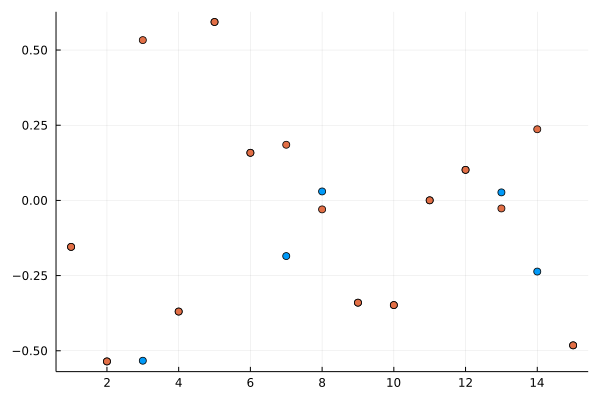

In [103]:
scatter(disLoops_y0[1:15, 1])
scatter!(Loops_y0[1:15, 1]; legend = false)

In [104]:
function getMaxLod(results::Array{Float64, 2})
    
    return mapslices(x -> maximum(x), results; dims = 2);
    
end

getMaxLod (generic function with 1 method)